# Deep Learning with Python

## 7.2 Inspecting and monitoring deep-learning models using Keras callbacks and TensorBoard

> 使用 Keras 回调函数和 TensorBoard 来检查并监控深度学习模型

用 model.fit() 开启一个复杂的训练任务后，我们就只能干等着，在结束前都不知道它有没有正确工作，也无法控制它，好似抛出了一架纸飞机，任它随风去往不确定的远方。比起这样不受控制的纸飞机，或许我们更希望要一台智能的无人机，可以感知环境，将数据发回给我们，并基于当前状态自主航行。 Keras 的回调函数与 TensorBoard 这样的工具就可以帮我们把“纸飞机”改造成“智能的无人机”。

### 训练中将回调函数作用于模型

我们在训练模型的时候，一开始是不知道要跑多少轮的，我们只能让它跑足够多的轮次，然后手动找出一个最佳的轮次数，重新用这个最佳轮次数去训练模型，这样相当耗时。所以，我们更希望当模型观测到验证损失不再改善时就自动停止训练。

这种操作就可以用 Keras 回调函数（callback）完成：Keras 提供了很多有用的 callback，放在 `keras.callbacks` 里，自动停止训练只是其中一种用法。

Callback 会在训练过程中的不同时间点被模型调用，它可以访问模型的状态，并可以采取一些行动，例如：

- 模型检查点：在训练过程中的不同时间点保存模型的当前权重
- 提前终止：验证损失不再改善时中断训练
- 动态调节参数值：例如动态调整优化器的学习率
- 记录训练指标和验证指标：用这些指标就可以将模型学到的表示可视化
- ...

#### 使用 callback

Keras 内置了许多有用的 callback，例如：

- `ModelCheckpoint`：在训练过程中保存训练到某些状态的模型。可以用来持续不断地保存模型，也可以选择性地保存目前的最佳模型；
- `EarlyStopping`：监控的目标指标，如果在设定的轮数内不再改善，则中断训练；
- `ReduceLROnPlateau`：在验证损失不再改善时（遇到loss plateau），降低学习率。

这些 callback 的使用也很简单：

```python
from tensorflow import keras

callbacks_list = [
    # 在每轮完成后保存权重
    keras.callbacks.ModelCheckpoint(
        filepath='my_model.h5',  # 保存文件的路径
        monitor='val_loss',      # monitor：要验证的指标
        save_best_only=True,     # 只保存让 monitor 指标最好的模型（如果 monitor 没有改善，就不保存）
    ),
    # 不再改善时中断训练
    keras.callbacks.EarlyStopping(
        monitor='acc',           # 要验证的指标
        patience=10,             # 如果 monitor 在多于 patience 轮内（比如这里就是10+1=11轮）没有改善，则中断训练
    ),
    # 不再改善时降低学习率
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',    # 要验证的指标
        factor=0.1,            # 触发时：学习率 *= factor
        patience=5,            # monitor 在 patience 轮内没有改善，则触发降低学习率
    ),
]

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])    # 在 callback 里用到了 acc 做指标，所以这里的 metrics 里要有 acc

model.fit(x, y, 
          epochs=10, 
          batch_size=32, 
          callbacks=callbacks_list,     # 训练时使用这些回调
          validation_data=(x_val, y_val))  # callback 里用到了 val，所以这里必须有 val
```

#### 编写自己的回调函数

除了使用 Keras 内置的回调，还可以自己写 callback 来完成内置没有的操作。

自己写回调通过创建 `keras.callbacks.Callback` 的子类来实现。和写游戏脚本很类似，在这个子类中实现一些方法，然后这些方法就会在训练过程中的特定时间点被调用：

| 方法            | 被调用的时间           |
| -------------- | -------------------- |
| on_epoch_begin | 在每轮开始时被调用      |
| on_epoch_end   | 在每轮结束时被调用      |
|                |                      |
| on_batch_begin | 在处理每个批量之前被调用 |
| on_batch_end   | 在处理每个批量之后被调用 |
|                |                      |
| on_train_begin | 在训练开始时被调用      |
| on_train_end   | 在训练结束时被调用      |

这些方法接受一个 logs 参数（dict类型的），里面包含前一个epoch 或 batch 或 train 的信息，包括训练指标、验证指标之类的。

在这些方法中，还可以访问：

- `self.model`: 调用回调的模型实例;
- `self.validation_data`: fit 传入的验证数据;

例如，我们编写一个自定义回调函数，在每轮结束后将模型每层对验证集的第一个样本的激活计算值保存下来：

In [3]:
from tensorflow import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):  # 在训练之前由父模型调用，告诉回调函数是哪个模型在调用它
        self.model = model
        layer_outputs = [layer.output for layer in model.layers]
        self.activations_model = keras.models.Model(model.input, layer_outputs)  # 模型实例，返回每层的激活
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
        validation_sample = self.validation_data[0][0:1]
        activations = self.activations_model.predict(validation_sample)
        with open(f'activations_at_epoch_{epoch}.npz', 'w') as f:
            np.savez(f, activations)

### TensorBoard 简介: TensorFlow 的可视化框架

为了做出更好模型，除了思考构架、编写代码，我们还需要获取关于模型的信息、了解训练过程中模型内部正在发生什么，并用这些信息来知道我们再思考、再优化模型。

思考是在你的脑子里完成的，编写模型的代码可以用 Keras API 轻松实现，而了解模型可以借用 TensorBoard。TensorBoard 是内置于 TensorFlow 中的基于浏览器的可视化工具，它能在训练过程中让你可视化地监控模型内部发生的一切。

![取得进展的循环](https://tva1.sinaimg.cn/large/007S8ZIlgy1ghp9tjfuzcj312g0d6acp.jpg)

TensorBoard 主要有一下几个作用：

- 在训练过程中以可视化的方式监控指标
- 将模型架构可视化
- 将激活和梯度的直方图可视化
- 以三维的形式研究嵌入

我们在 IMDB 情感分析任务上训练一个一维卷积神经网络，来演示 TensorBoard 的使用:

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = keras.models.Sequential()
model.add(layers.Embedding(max_features, 128,
                           input_length=max_len,
                           name='embed'))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(1))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

要使用 TensorBoard，在开始训练之前还需要做一些准备。首先，为 TensorBoard 需要的日志文件创建一个目录，并开启 TensorBoard 的服务。在 shell 里：

```shell
$ mkdir my_log_dir
```

或者，在 Jupyter Notebook 中：

In [21]:
%mkdir my_log_dir

然后，实例化一个 TensorBoard 回调函数：

In [22]:
import tensorflow as tf

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='my_log_dir',  # 日志文件的储存位置
    histogram_freq=1,      # 每 histogram_freq 轮之后记录激活直方图
    embeddings_freq=1,     # 每 histogram_freq 轮之后记录词嵌入
)

最后，在训练时使用这个回调就可以了：

In [23]:
history = model.fit(x_train, y_train, 
                    epochs=20, 
                    batch_size=128, 
                    validation_split=0.2, 
                    callbacks=[tensorboard_callback])

Epoch 1/20
157/157 [==============================] - 25s 156ms/step - loss: 0.6376 - acc: 0.6424 - val_loss: 0.7053 - val_acc: 0.7210
Epoch 2/20
157/157 [==============================] - 24s 152ms/step - loss: 0.4426 - acc: 0.8489 - val_loss: 0.5328 - val_acc: 0.8378
Epoch 3/20
157/157 [==============================] - 25s 161ms/step - loss: 0.3988 - acc: 0.8807 - val_loss: 0.4488 - val_acc: 0.8688
Epoch 4/20
157/157 [==============================] - 24s 155ms/step - loss: 0.3680 - acc: 0.8965 - val_loss: 0.5022 - val_acc: 0.8714
Epoch 5/20
157/157 [==============================] - 25s 162ms/step - loss: 0.3123 - acc: 0.9168 - val_loss: 0.4771 - val_acc: 0.8688
Epoch 6/20
157/157 [==============================] - 25s 162ms/step - loss: 0.2550 - acc: 0.9387 - val_loss: 0.7022 - val_acc: 0.8640
Epoch 7/20
157/157 [==============================] - 24s 156ms/step - loss: 0.2419 - acc: 0.9470 - val_loss: 0.7245 - val_acc: 0.8758
Epoch 8/20
157/157 [==============================] - 2

开始训练之后，就可以开启 TensorBoard 服务：

```shell
$ tensorboard --logdir=my_log_dir
```

或者在 Jupyter Notebook 里：

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=my_log_dir

现在就可以在浏览器中打开 `http://localhost:6006` 来查看 TensorBoard 的可视化模型的训练过程了。

- Scalars 标签页中，可以看到训练过程中精度、损失的变化曲线，和我们之前每次训练完之后用 plt 画的是同样的内容，不过在  TensorBoard 里你可以随时刷新去看，不用等到训练完成；
- Graph 标签页中，显示的是 Keras 模型背后的底层 TensorFlow 运算图的可视化，这个底层运算图比我们的 Keras 模型复杂，这就是 Keras 为我们简化的工作，Keras 让我们不去接触那些复杂的东西，让工作流程变得非常简单；如果你想看 Keras 模型本身的图表示，可以用 `keras.utils.plot_model`：

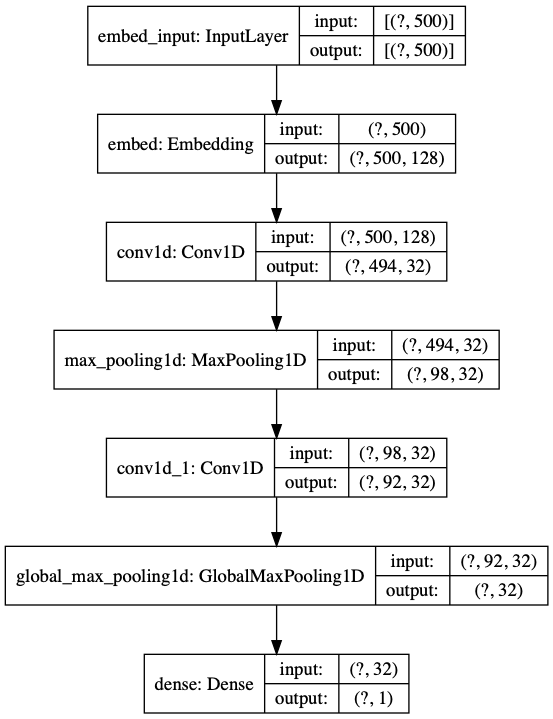

In [3]:
import tensorflow as tf

tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')
# show_shapes=True 可以把各层的输入输出张量形状显示出来

- Histograms 标签页中，有每层的激活值直方图；
- Projector 标签页中，有我们的词表中 2000 个单词的词嵌入空间关系。这是由 Embedding 层学习到的 128 维的嵌入空间用 PCA 之类的算法降到 2 维或者 3 维后得到的“投影”影像。如果你对里面每个点的意义感兴趣，可以点击某个点，查看其编号，然后用下面的代码还原出单词来看看：

In [40]:
index_word = {v: k for k, v in imdb.get_word_index().items()}
def show_word_of_index(idx):  # idx 输入看到的词编号
    print(index_word[idx])

show_word_of_index(123)

ever
